<a href="https://colab.research.google.com/github/SandroPaiva/desafio_redes_neurais_com_tranferlearning/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizado por transferência / ajuste fino
Este tutorial o guiará pelo processo de utilização do aprendizado por transferência para aprender um classificador de imagens preciso a partir de um número relativamente pequeno de amostras de treinamento. De modo geral, o aprendizado por transferência refere-se ao processo de aproveitar o conhecimento aprendido em um modelo para o treinamento de outro modelo.

Mais especificamente, o processo envolve pegar uma rede neural existente, previamente treinada para obter um bom desempenho em um conjunto de dados maior, e usá-la como base para um novo modelo que aproveita a precisão dessa rede anterior para uma nova tarefa. Esse método se tornou popular nos últimos anos para melhorar o desempenho de uma rede neural treinada em um conjunto de dados pequeno; a intuição é que o novo conjunto de dados pode ser pequeno demais para ser treinado para um bom desempenho por si só, mas sabemos que a maioria das redes neurais treinadas para aprender características de imagem frequentemente aprendem características semelhantes de qualquer maneira, especialmente nas camadas iniciais, onde são mais genéricas (detectores de borda, bolhas e assim por diante).

O aprendizado por transferência foi amplamente possibilitado pelo código aberto de modelos de última geração; Para os modelos de melhor desempenho em tarefas de classificação de imagens (como os de ILSVRC), é prática comum não apenas publicar a arquitetura, mas também liberar os pesos treinados do modelo. Isso permite que amadores usem esses classificadores de imagens de ponta para aprimorar o desempenho de seus próprios modelos específicos para tarefas.

Extração de características vs. ajuste fino
Em um extremo, o aprendizado por transferência pode envolver pegar a rede pré-treinada e congelar os pesos, e usar uma de suas camadas ocultas (geralmente a última) como extrator de características, usando essas características como entrada para uma rede neural menor.

No outro extremo, começamos com a rede pré-treinada, mas permitimos que alguns dos pesos (geralmente a última camada ou as últimas camadas) sejam modificados. Outro nome para esse procedimento é "ajuste fino", pois estamos ajustando ligeiramente os pesos da rede pré-treinada para a nova tarefa. Geralmente, treinamos essa rede com uma taxa de aprendizado menor, pois esperamos que os recursos já sejam relativamente bons e não precisem ser alterados em demasia.

Às vezes, fazemos algo intermediário: congelamos apenas as camadas iniciais/genéricas, mas ajustamos as camadas posteriores. A melhor estratégia depende do tamanho do seu conjunto de dados, do número de classes e de quanto ele se assemelha ao conjunto de dados no qual o modelo anterior foi treinado (e, portanto, se ele pode se beneficiar dos mesmos extratores de recursos aprendidos). Uma discussão mais detalhada sobre como elaborar estratégias pode ser encontrada em [1] [2].

Procedimento
Neste guia, abordaremos o processo de carregamento de um classificador de imagens de última geração, com 1000 classes, VGG16, que venceu o desafio ImageNet em 2014, e o utilizaremos como um extrator de características fixas para treinar um classificador personalizado menor em nossas próprias imagens. Embora, com poucas alterações no código, você também possa tentar fazer ajustes finos.

Primeiramente, carregaremos o VGG16 e removeremos sua camada final, a camada de classificação softmax de 1000 classes específica do ImageNet, e a substituiremos por uma nova camada de classificação para as classes que estamos treinando. Em seguida, congelaremos todos os pesos na rede, exceto os novos que se conectam à nova camada de classificação, e então treinaremos a nova camada de classificação sobre nosso novo conjunto de dados.

Também compararemos esse método ao treinamento de uma pequena rede neural do zero no novo conjunto de dados e, como veremos, ele aumentará drasticamente nossa precisão. Faremos essa parte primeiro.

Como objeto de teste, usaremos um conjunto de dados composto por cerca de 6.000 imagens pertencentes a 97 classes e treinaremos um classificador de imagens com cerca de 80% de precisão. Vale ressaltar que essa estratégia se adapta bem a conjuntos de imagens onde você pode ter apenas algumas centenas de imagens ou menos. Seu desempenho será inferior a um pequeno número de amostras (dependendo das classes), como de costume, mas ainda impressionante considerando as restrições usuais.

In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Obtendo um conjunto de dados

O primeiro passo será carregar nossos dados. Como exemplo, usaremos o conjunto de dados [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), que contém cerca de 9.000 imagens rotuladas pertencentes a 101 categorias de objetos. No entanto, excluiremos 5 das categorias que possuem o maior número de imagens. Isso serve para manter a distribuição das classes razoavelmente equilibrada (em torno de 50 a 100) e restrita a um número menor de imagens, em torno de 6.000.

Para obter este conjunto de dados, você pode executar o script de download `download.sh` na pasta `data` ou os seguintes comandos:

wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
tar -xvzf 101_ObjectCategories.tar.gz

Se desejar usar seu próprio conjunto de dados, ele deve ser organizado da mesma forma que `101_ObjectCategories`, com todas as imagens organizadas em subpastas, uma para cada classe. Nesse caso, a célula a seguir deve carregar seu conjunto de dados personalizado corretamente, bastando substituir `root` pela sua pasta. Se você tiver uma estrutura alternativa, basta certificar-se de carregar a lista `data`, onde cada elemento é um dicionário, onde `x` é o dado (um array numpy unidimensional) e `y` é o rótulo (um inteiro). Use a função auxiliar `get_image(path)` para carregar a imagem corretamente no array e observe também que as imagens estão sendo redimensionadas para 224x224. Isso é necessário porque a entrada para VGG16 é uma imagem RGB de 224x224. Você não precisa redimensioná-las no seu disco rígido, pois isso está sendo feito no código abaixo.

Se você tiver `101_ObjectCategories` na sua pasta de dados, a célula a seguir deverá carregar todos os dados.

In [2]:
root = 'KamenRider'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['KamenRider/.ipynb_checkpoints', 'KamenRider/Zeztz', 'KamenRider/Kabuto']


Esta função é útil para pré-processar os dados em uma imagem e um vetor de entrada.

In [3]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregue todas as imagens da pasta raiz

In [4]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        try:
            img, x = get_image(img_path)
            data.append({'x':np.array(x[0]), 'y':c})
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")


# count the number of classes
num_classes = len(categories)

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Randomize a ordem dos dados.



In [5]:
random.shuffle(data)

criar divisão de treinamento/validação/teste (70%, 15%, 15%)

In [6]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Dados separados para rótulos.

In [7]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2]


Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [8]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(24, 3)


Vamos fazer um resumo do que temos.

In [9]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 156 images from 3 categories
train / validation / test split: 109, 23, 24
training data shape:  (109, 224, 224, 3)
training labels shape:  (109, 3)


Se tudo funcionou corretamente, você deve ter carregado um monte de imagens e dividido-as em três conjuntos: `train`, `val` e `test`. O formato dos dados de treinamento deve ser (`n`, 224, 224, 3), onde `n` é o tamanho do seu conjunto de treinamento, e os rótulos devem ser (`n`, `c`), onde `c` é o número de classes.

Observe que dividimos todos os dados em três subconjuntos — um conjunto de treinamento `train`, um conjunto de validação `val` e um conjunto de teste `test`. O motivo disso é avaliar adequadamente a precisão do nosso classificador. Durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem sobreajuste ao conjunto de treinamento. O conjunto `test` é sempre mantido fora do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.

Vamos dar uma olhada rápida em algumas imagens de exemplo do nosso conjunto de dados.

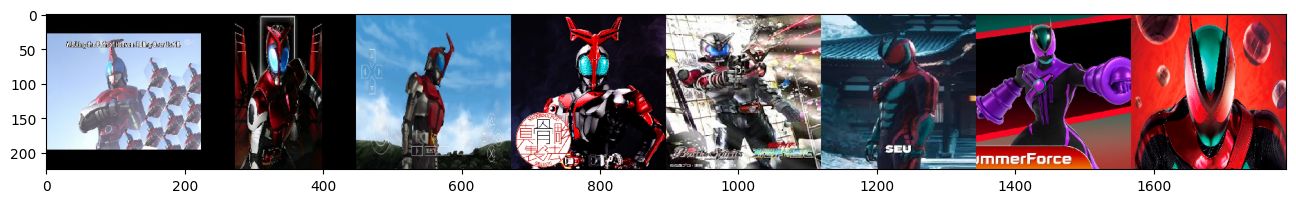

In [10]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### Primeiro, treinando uma rede neural do zero

Antes de realizar o aprendizado por transferência, vamos construir uma rede neural do zero para realizar a classificação em nosso conjunto de dados. Isso nos dará uma linha de base para comparar com nossa rede aprendida por transferência posteriormente.

A rede que construiremos contém 4 camadas convolucionais e de pooling máximo alternadas, seguidas por um [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) após cada par conv/pooling. Após a última camada de pooling, anexaremos uma camada totalmente conectada com 256 neurônios, outra camada de dropout e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como de costume, perda de entropia cruzada categórica, e nosso algoritmo de aprendizado será [AdaDelta](https://arxiv.org/abs/1212.5701). Vários aspectos desta rede podem ser alterados para obter melhor desempenho. Talvez usar uma rede maior ou um otimizador diferente ajude, mas, para os propósitos deste notebook, o objetivo é apenas obter uma base aproximada para fins de comparação, portanto, não é necessário gastar muito tempo tentando otimizar esta rede.

Após compilar a rede, vamos executar `model.summary()` para obter um instantâneo de suas camadas.

In [11]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,315 (4.61 MB)

 Trainable params: 1,209,315 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Criamos uma rede de médio porte com aproximadamente 1,2 milhão de pesos e vieses (os parâmetros). A maioria deles leva à camada totalmente conectada pré-softmax "dense_5".

Agora podemos prosseguir e treinar nosso modelo para 100 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos plotar a perda ao longo do tempo posteriormente.

In [12]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.3761 - loss: 1.0964 - val_accuracy: 0.5652 - val_loss: 0.8190
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.6422 - loss: 0.7416 - val_accuracy: 0.5652 - val_loss: 0.7376
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5688 - loss: 0.6853 - val_accuracy: 0.6087 - val_loss: 0.7119
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6330 - loss: 0.6507 - val_accuracy: 0.5652 - val_loss: 0.6984
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6697 - loss: 0.6261 - val_accuracy: 0.5652 - val_loss: 0.7043
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6422 - loss: 0.6358 - val_accuracy: 0.5652 - val_loss: 0.6617
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.6881 - loss: 0.5517 - val_accuracy: 0.6957 - val_loss: 0.6268
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7339 - loss: 0.5432 - val_accuracy: 0.6087 - val_loss: 0.6165
Epoch 9/10

Vamos traçar a perda de validação e a precisão da validação ao longo do tempo.

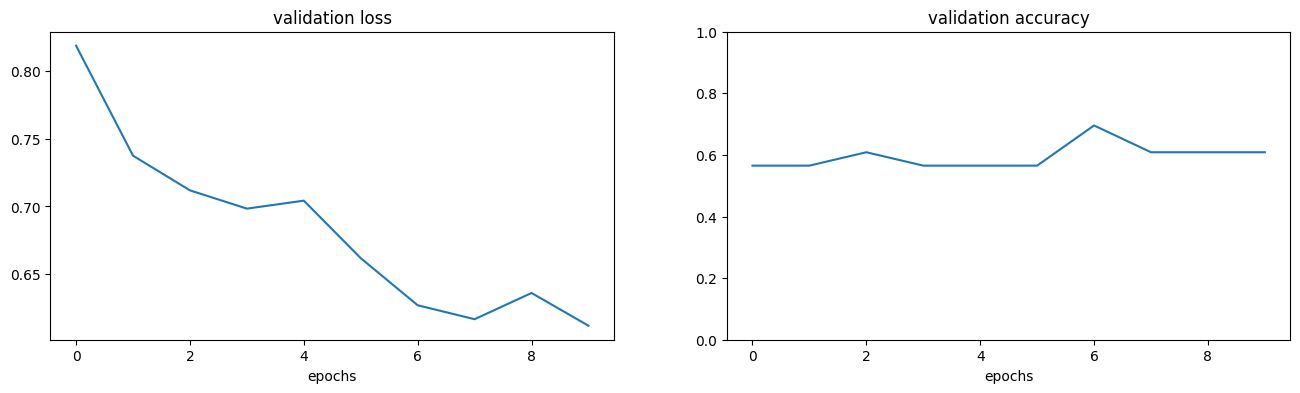

In [13]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que a perda de validação começa a aumentar após cerca de 16 épocas, embora a precisão da validação permaneça aproximadamente entre 40% e 50%. Isso sugere que nosso modelo começa a apresentar overfitting por volta dessa época, e o melhor desempenho teria sido alcançado se tivéssemos parado cedo nessa época. No entanto, nossa precisão provavelmente não teria sido superior a 50%, e provavelmente menor.

Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:

In [14]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.8121821880340576
Test accuracy: 0.5


Por fim, vemos que alcançamos uma precisão (top-1) de cerca de 49%. Isso não é tão ruim para 6.000 imagens, considerando que, se tivéssemos usado uma estratégia ingênua de fazer suposições aleatórias, teríamos obtido apenas cerca de 1% de precisão.

## Transferência de aprendizado começando com a rede existente

Agora podemos passar para a estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começar com uma rede maior e já treinada.

Para começar, carregaremos o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta for a primeira vez que você carrega o VGG16, precisará aguardar um pouco para que os pesos sejam baixados da web. Assim que a rede for carregada, podemos inspecionar as camadas novamente com o método `summary()`.

In [15]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Observe que o VGG16 é _muito_ maior do que a rede que construímos anteriormente. Ele contém 13 camadas convolucionais e duas camadas totalmente conectadas no final, e possui mais de 138 milhões de parâmetros, cerca de 100 vezes mais parâmetros do que a rede que criamos acima. Assim como nossa primeira rede, a maioria dos parâmetros é armazenada nas conexões que levam à primeira camada totalmente conectada.

O VGG16 foi criado para resolver o ImageNet e atinge uma [taxa de erro de 8,8% nas 5 principais previsões](https://github.com/jcjohnson/cnn-benchmarks), o que significa que 91,2% das amostras de teste foram classificadas corretamente dentro das 5 principais previsões para cada imagem. Sua precisão de 1ª ordem — equivalente à métrica de precisão que temos usado (de que a previsão principal está correta) — é de 73%. Isso é especialmente impressionante, pois não há apenas 97, mas 1.000 classes, o que significa que palpites aleatórios nos dariam apenas 0,1% de precisão.

Para usar essa rede em nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 97 neurônios no caso do conjunto de dados 101_ObjectCategories.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG de sua camada de entrada até a penúltima camada e, em seguida, trabalhar com ela, em vez de modificar o objeto VGG diretamente. Portanto, tecnicamente, nunca "removemos" nada, apenas o contornamos/ignoramos. Isso pode ser feito da seguinte maneira: usando a classe `Model` do keras para inicializar um novo modelo cuja camada de entrada é a mesma do VGG, mas cuja camada de saída é nossa nova camada softmax, chamada `new_classification_layer`. Observação: embora pareça que estamos duplicando essa grande rede, internamente o Keras está apenas copiando todas as camadas por referência e, portanto, não precisamos nos preocupar em sobrecarregar a memória.

In [16]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Vamos retreinar esta rede, `model_new`, no novo conjunto de dados e rótulos. Mas, primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto a nova no final, com a expectativa de que os recursos aprendidos no VGG ainda sejam razoavelmente relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente é melhor do que podemos treinar em nosso conjunto de dados limitado.

Ao definir o sinalizador `trainable` em cada camada como falso (exceto em nossa nova camada de classificação), garantimos que todos os pesos e vieses nessas camadas permaneçam fixos e simplesmente treinamos os pesos na camada final. Em alguns casos, é desejável *não* congelar todas as camadas de pré-classificação. Se o seu conjunto de dados tiver amostras suficientes e não se assemelhar muito ao ImageNet, pode ser vantajoso ajustar algumas das camadas do VGG junto com o novo classificador, ou possivelmente até mesmo todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais camadas treináveis.

No caso do CalTech-101, faremos apenas a extração de características, temendo que o ajuste fino excessivo neste conjunto de dados possa causar overfitting. Mas talvez estejamos errados? Um bom exercício seria testar ambos e comparar os resultados.

Então, congelamos as camadas e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda da nossa primeira rede, para fins de comparação justa. Em seguida, executamos `summary` novamente para analisar a arquitetura da rede.

In [17]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,272,835 (512.21 MB)

 Trainable params: 12,291 (48.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Observando o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto que a última camada, anteriormente um softmax de 1.000 neurônios, foi substituída por um novo softmax de 97 neurônios. Além disso, ainda temos aproximadamente 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis" porque congelamos as camadas em que estão contidos. Agora, temos apenas 397.000 parâmetros treináveis, o que representa apenas um quarto do número de parâmetros necessários para treinar o primeiro modelo.

Como antes, seguimos em frente e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, juntamente com o mesmo algoritmo de otimização. Também monitoramos seu histórico à medida que avançamos.

In [18]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 89s 89s/step - accuracy: 0.6422 - loss: 0.8214 - val_accuracy: 0.4348 - val_loss: 1.4883
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 79s 79s/step - accuracy: 0.3578 - loss: 1.6849 - val_accuracy: 0.5217 - val_loss: 0.7184
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 89s 89s/step - accuracy: 0.3486 - loss: 0.7800 - val_accuracy: 0.5652 - val_loss: 0.9870
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 85s 85s/step - accuracy: 0.6422 - loss: 0.8727 - val_accuracy: 0.5652 - val_loss: 1.3440
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 78s 78s/step - accuracy: 0.6422 - loss: 1.1417 - val_accuracy: 0.5652 - val_loss: 1.2828
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step - accuracy: 0.6422 - loss: 1.0805 - val_accuracy: 0.5652 - val_loss: 0.9574
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 85s 85s/step - accuracy: 0.6422 - loss: 0.8149 - val_accuracy: 0.5652 - val_loss: 0.6572
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 144s 144s/step - accuracy: 0.6606 - loss: 0.6084 - val_accuracy: 0.5217 - val_loss: 0.704

Nossa precisão de validação gira em torno de 80% no final, o que representa uma melhoria de mais de 30% em relação à rede original treinada do zero (o que significa que fizemos a previsão errada em 20% das amostras, em vez de 50%).

Vale notar também que esta rede, na verdade, treina _um pouco mais rápido_ do que a rede original, apesar de ter mais de 100 vezes mais parâmetros! Isso ocorre porque congelar os pesos elimina a necessidade de retropropagação por todas essas camadas, economizando tempo de execução.

Vamos plotar a perda e a precisão da validação novamente, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo aprendido por transferência em verde.

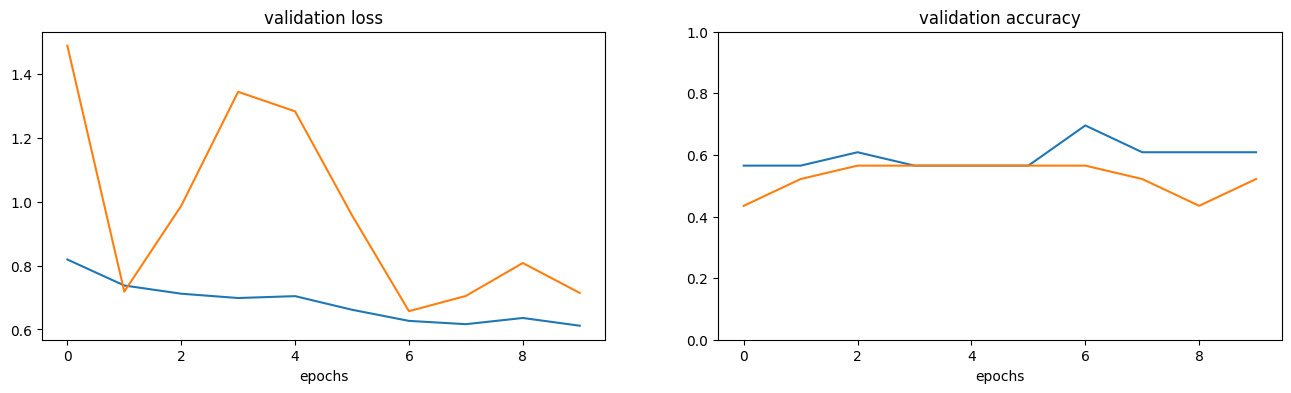

In [19]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que, enquanto o modelo original começou a apresentar sobreajuste por volta da época 16, o novo modelo continuou a diminuir lentamente sua perda ao longo do tempo e provavelmente teria melhorado ligeiramente sua precisão com mais iterações. O novo modelo atingiu aproximadamente 80% de precisão top-1 (no conjunto de validação) e continuou a melhorar lentamente ao longo de 100 épocas.

É possível que pudéssemos ter melhorado o modelo original com melhor regularização ou mais dropouts, mas certamente não teríamos recuperado a melhoria de mais de 30% na precisão.

Novamente, fazemos uma validação final no conjunto de teste.

In [20]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.7453503608703613
Test accuracy: 0.5


Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

In [21]:
img, x = get_image('KamenRider/Kabuto/kabuto_019.jpg')
probabilities = model_new.predict([x])


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_211
Received: inputs=('Tensor(shape=(1, 224, 224, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


### Melhorando os resultados

78,2% de precisão top-1 em 97 classes, distribuídas de forma aproximadamente uniforme, é uma conquista bastante boa. Não é tão impressionante quanto o VGG16 original, que atingiu 73% de precisão top-1 em 1.000 classes. No entanto, é muito melhor do que conseguimos com nossa rede original, e há espaço para melhorias. Algumas técnicas que possivelmente poderiam ter melhorado nosso desempenho.

- Usando a ampliação de dados: ampliação refere-se ao uso de várias modificações dos dados de treinamento originais, na forma de distorções, rotações, redimensionamentos, alterações de iluminação, etc., para aumentar o tamanho do conjunto de treinamento e criar mais tolerância a tais distorções.
- Usando um otimizador diferente, adicionando mais regularização/dropout e outros hiperparâmetros.
- Treinamento por mais tempo (claro)

Um exemplo mais avançado de aprendizagem por transferência no Keras, envolvendo aumento para um pequeno conjunto de dados de duas classes, pode ser encontrado no [blog do Keras](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).